In [133]:
!pip install unidecode
!pip install vaderSentiment

In [134]:
import pandas as pd
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from unidecode import unidecode
from google.colab import files
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba
from sklearn.decomposition import PCA
import seaborn as sns
from datetime import timedelta
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [135]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
with open(filename, 'r', encoding='utf-8') as file:
    text_corpus = file.read()

Saving corpus.txt to corpus (5).txt


In [136]:
print(text_corpus[:500])

[11.7.2023, 6:56:49] כו"ח - על כל שאלה תשובה 🎼: ‏ההודעות והשיחות מוצפנות מקצה לקצה. לאף אחד מחוץ לצ'אט הזה, גם לא ל-WhatsApp, אין אפשרות לקרוא אותן ולהאזין להן.
[21.8.2023, 17:32:38] רועי מרלי: ‏סקר:
חברת *שידורית* זכתה במכרז של משרד הרווחה לאספקת שירותי *תרגום מרחוק בשפת הסימנים* לזכאים בלבד. האם את/ה מכיר/ה את השירות המוצע בשפת הסימנים (לא תיווך בכתב). נבקש כי רק חירשים וכבדי שמיעה יענו.
‏אפשרות: כן - השירות טוב (0 הצבעות)
‏אפשרות: כן - השירות לא טוב (הצבעה אחת)
‏אפשרות: לא מכיר את השירות (14 


In [137]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

text_corpus_cleaned = remove_emojis(text_corpus)

In [138]:
print(text_corpus_cleaned[:800])

[11.7.2023, 6:56:49] כו"ח - על כל שאלה תשובה : ‏ההודעות והשיחות מוצפנות מקצה לקצה. לאף אחד מחוץ לצ'אט הזה, גם לא ל-WhatsApp, אין אפשרות לקרוא אותן ולהאזין להן.
[21.8.2023, 17:32:38] רועי מרלי: ‏סקר:
חברת *שידורית* זכתה במכרז של משרד הרווחה לאספקת שירותי *תרגום מרחוק בשפת הסימנים* לזכאים בלבד. האם את/ה מכיר/ה את השירות המוצע בשפת הסימנים (לא תיווך בכתב). נבקש כי רק חירשים וכבדי שמיעה יענו.
‏אפשרות: כן - השירות טוב (0 הצבעות)
‏אפשרות: כן - השירות לא טוב (הצבעה אחת)
‏אפשרות: לא מכיר את השירות (14 הצבעות)
[8.10.2023, 22:22:51] יעל גורן (מפילדלפיה): האם יש אפשרות באפליקציה לשנות את צליל ההתראה מסירנה למשהו אחר? לא מצאתי אופציה כזו. 
בצבע אדום כן היה. 
זה פשוט עושה התקף לב הצליל של סירנה באמצע שינה. 
מחפשת משהו שישמע יותר כמו שעון מעורר. אבל אין אופציה לשנות בתפריט אלא אם מישהו כאן מכיר.
[22.10.


In [159]:
def create_dataframe(text):
    messages = []
    pattern = r'\[(\d+\.\d+\.\d+), (\d+:\d+:\d+)\] (.*?): (.+)'
    for line in text.split('\n'):
        match = re.match(pattern, line)
        if match:
            date = match.group(1)
            time = match.group(2)
            person = match.group(3)
            message = match.group(4)
            messages.append((date, time, person, message))
    df = pd.DataFrame(messages, columns=['date', 'time', 'person', 'message'])
    return df

# Create DataFrame
df = create_dataframe(text_corpus_cleaned)
display(df)
df.info()

,date,time,person,message
0,11.7.2023,6:56:49,"כו""ח - על כל שאלה תשובה",‏ההודעות והשיחות מוצפנות מקצה לקצה. לאף אחד מח...
1,21.8.2023,17:32:38,רועי מרלי,‏סקר:
2,8.10.2023,22:22:51,יעל גורן (מפילדלפיה),האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...
3,22.10.2023,23:15:45,יניב פיבו,‫‏לירית שפיר שמש הסיר/ה את יניב פיבו‬
4,22.10.2023,23:20:16,~ M.B.N. ltd,‫‏לירית שפיר שמש הסיר/ה את ~ M.B.N. ltd‬
...,...,...,...,...
1541,7.11.2023,11:40:51,דורית בן שלום,מה שהצעתי .
1542,7.11.2023,11:41:06,רונן ברנוי,יאללה חמודים/ות... יאללה...
1543,7.11.2023,11:41:16,יעקב וובר,כמו שאמרתי אין השבע יודע את מצוקת הרעב
1544,7.11.2023,12:00:33,~ Meitav,כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     1546 non-null   object
 1   time     1546 non-null   object
 2   person   1546 non-null   object
 3   message  1546 non-null   object
dtypes: object(4)
memory usage: 48.4+ KB


In [140]:
df_copy = df

# Define Hebrew stopwords
heb_stopwords = set(stopwords.words('hebrew'))

# Manually add additional stopwords
additional_stopwords = {'שיש', 'שלא', 'וזה', 'וגם', 'שזה', 'ההודעה','נערכה','הצטרףה','הזה','בכל','כמה','נמחקה','ניתן','מאוד',
'נכון','תודה','קישור','לקבוצה','האם','מישהו','בכלל','לך','מאוד','למי','לזה','צריך','ממש','כבר','ולא','נכון','אחד','אפשר','הכל','לכל'
,'הכי','זו','הודעה','עידו','זו', 'בדיוק', 'בה', 'היו', 'ללא', 'טוב', 'חחח'}
heb_stopwords.update(additional_stopwords)

# Function to clean and preprocess text
def clean_text(text):
    # Remove non-text characters
    text = re.sub(r'[^\w\s]', '', text)
    # Normalize text (convert to lowercase)
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in heb_stopwords]
    # Join tokens back into text
    cleaned_text = ' '.join(tokens)
    return cleaned_text

df_copy['cleaned_message'] = df_copy['message'].apply(clean_text)

In [141]:
display(df_copy)
df_copy.info()

,date,time,person,message,cleaned_message
0,11.7.2023,6:56:49,"כו""ח - על כל שאלה תשובה",‏ההודעות והשיחות מוצפנות מקצה לקצה. לאף אחד מח...,ההודעות והשיחות מוצפנות מקצה לקצה לאף לצאט לwh...
1,21.8.2023,17:32:38,רועי מרלי,‏סקר:,סקר
2,8.10.2023,22:22:51,יעל גורן (מפילדלפיה),האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...,אפשרות באפליקציה לשנות צליל ההתראה מסירנה למשה...
3,22.10.2023,23:15:45,יניב פיבו,‫‏לירית שפיר שמש הסיר/ה את יניב פיבו‬,לירית שפיר שמש הסירה יניב פיבו
4,22.10.2023,23:20:16,~ M.B.N. ltd,‫‏לירית שפיר שמש הסיר/ה את ~ M.B.N. ltd‬,לירית שפיר שמש הסירה mbn ltd
...,...,...,...,...,...
1541,7.11.2023,11:40:51,דורית בן שלום,מה שהצעתי .,שהצעתי
1542,7.11.2023,11:41:06,רונן ברנוי,יאללה חמודים/ות... יאללה...,יאללה חמודיםות יאללה
1543,7.11.2023,11:41:16,יעקב וובר,כמו שאמרתי אין השבע יודע את מצוקת הרעב,שאמרתי השבע יודע מצוקת הרעב
1544,7.11.2023,12:00:33,~ Meitav,כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...,חכמה גדולה והבנה מושלמת והבנה לוקה בחוסר


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             1546 non-null   object
 1   time             1546 non-null   object
 2   person           1546 non-null   object
 3   message          1546 non-null   object
 4   cleaned_message  1546 non-null   object
dtypes: object(5)
memory usage: 60.5+ KB


In [142]:
# Date and Time Parsing
df_copy['datetime'] = pd.to_datetime(df_copy['date'] + ' ' + df_copy['time'], format='%d.%m.%Y %H:%M:%S')

# Message Length
df_copy['message_length'] = df_copy['message'].apply(len)

# Word Count
df_copy['word_count'] = df_copy['message'].apply(lambda x: len(nltk.word_tokenize(x)))

# Time of Day Analysis
df_copy['hour_of_day'] = df_copy['datetime'].dt.hour

# Day of Week Analysis with Sunday as the first day of the week
df_copy['day_of_week'] = (df_copy['datetime'].dt.dayofweek + 1) % 7

# Remove numbers and URLs from the "cleaned_message" column
def remove_numbers_and_urls(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

df_copy['cleaned_message'] = df_copy['cleaned_message'].apply(remove_numbers_and_urls)

display(df_copy)
df_copy.info()

,date,time,person,message,cleaned_message,datetime,message_length,word_count,hour_of_day,day_of_week
0,11.7.2023,6:56:49,"כו""ח - על כל שאלה תשובה",‏ההודעות והשיחות מוצפנות מקצה לקצה. לאף אחד מח...,ההודעות והשיחות מוצפנות מקצה לקצה לאף לצאט לwh...,2023-07-11 06:56:49,112,23,6,2
1,21.8.2023,17:32:38,רועי מרלי,‏סקר:,סקר,2023-08-21 17:32:38,5,2,17,1
2,8.10.2023,22:22:51,יעל גורן (מפילדלפיה),האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...,אפשרות באפליקציה לשנות צליל ההתראה מסירנה למשה...,2023-10-08 22:22:51,84,17,22,0
3,22.10.2023,23:15:45,יניב פיבו,‫‏לירית שפיר שמש הסיר/ה את יניב פיבו‬,לירית שפיר שמש הסירה יניב פיבו,2023-10-22 23:15:45,37,7,23,0
4,22.10.2023,23:20:16,~ M.B.N. ltd,‫‏לירית שפיר שמש הסיר/ה את ~ M.B.N. ltd‬,לירית שפיר שמש הסירה mbn ltd,2023-10-22 23:20:16,40,9,23,0
...,...,...,...,...,...,...,...,...,...,...
1541,7.11.2023,11:40:51,דורית בן שלום,מה שהצעתי .,שהצעתי,2023-11-07 11:40:51,11,3,11,2
1542,7.11.2023,11:41:06,רונן ברנוי,יאללה חמודים/ות... יאללה...,יאללה חמודיםות יאללה,2023-11-07 11:41:06,27,5,11,2
1543,7.11.2023,11:41:16,יעקב וובר,כמו שאמרתי אין השבע יודע את מצוקת הרעב,שאמרתי השבע יודע מצוקת הרעב,2023-11-07 11:41:16,38,8,11,2
1544,7.11.2023,12:00:33,~ Meitav,כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...,חכמה גדולה והבנה מושלמת והבנה לוקה בחוסר,2023-11-07 12:00:33,56,11,12,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1546 non-null   object        
 1   time             1546 non-null   object        
 2   person           1546 non-null   object        
 3   message          1546 non-null   object        
 4   cleaned_message  1546 non-null   object        
 5   datetime         1546 non-null   datetime64[ns]
 6   message_length   1546 non-null   int64         
 7   word_count       1546 non-null   int64         
 8   hour_of_day      1546 non-null   int64         
 9   day_of_week      1546 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 120.9+ KB


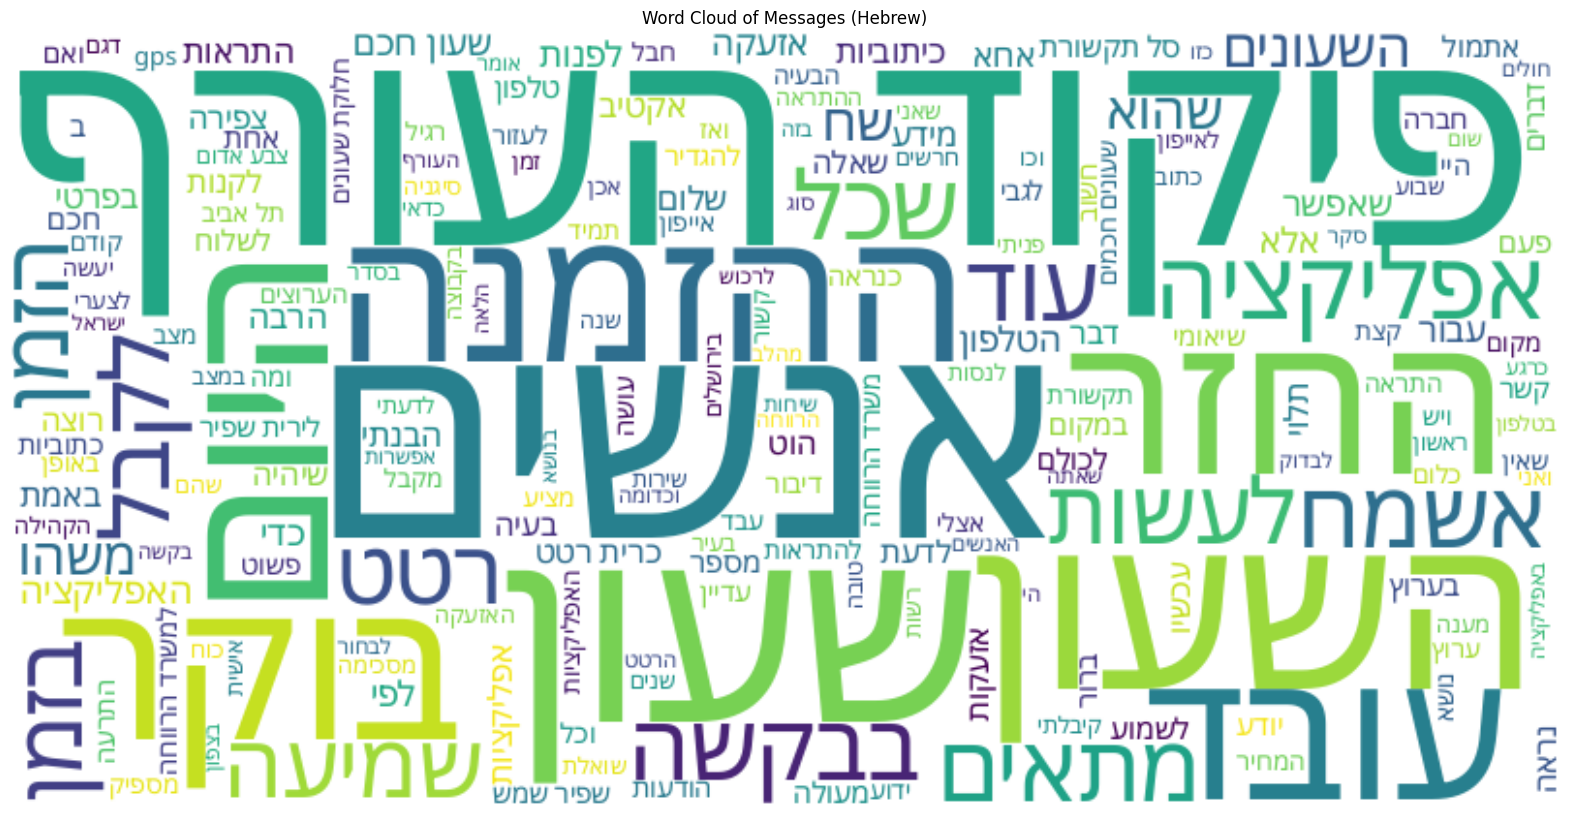

In [143]:
hebrew_text = ' '.join(df_copy['cleaned_message'])
cmap = plt.get_cmap('viridis')

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap=cmap,
    font_path='./NotoSansHebrew-VariableFont_wdth,wght.ttf'
).generate(hebrew_text)

plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Messages (Hebrew)')
plt.show()

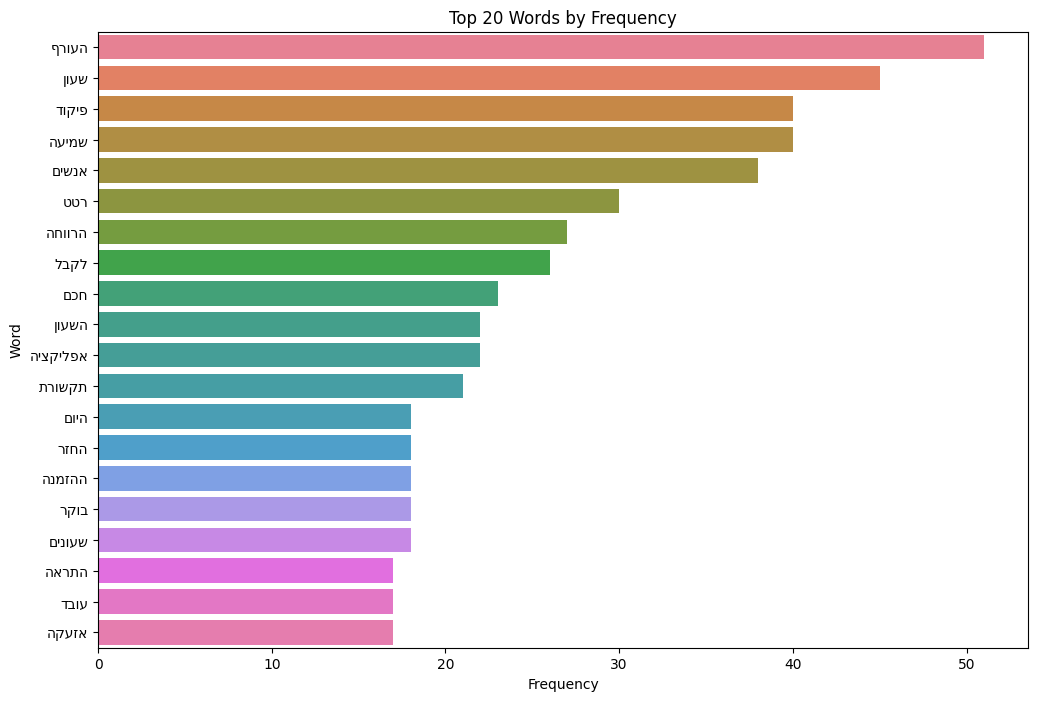

In [144]:
# Create bag of words
bag_of_words = ' '.join(df_copy['cleaned_message'])

# Tokenize the bag of words
tokens = bag_of_words.split()

# Count word occurrences
word_counts = Counter(tokens)

# Convert word counts to DataFrame for easier plotting
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])

# Sort the DataFrame by Count in descending order
word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

# Plot word counts
reversed_words = [word[::-1] for word in word_counts_df['Word']]
plt.figure(figsize=(12, 8))
sns.barplot(data=word_counts_df.head(20), x='Count', y=reversed_words[:20], hue=reversed_words[:20], legend=False)
plt.title('Top 20 Words by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [145]:
## For more insights, using external data of missile alerts timestamps from - https://public.tableau.com/app/profile/igal3138/viz/shared/TPK9KRNTP

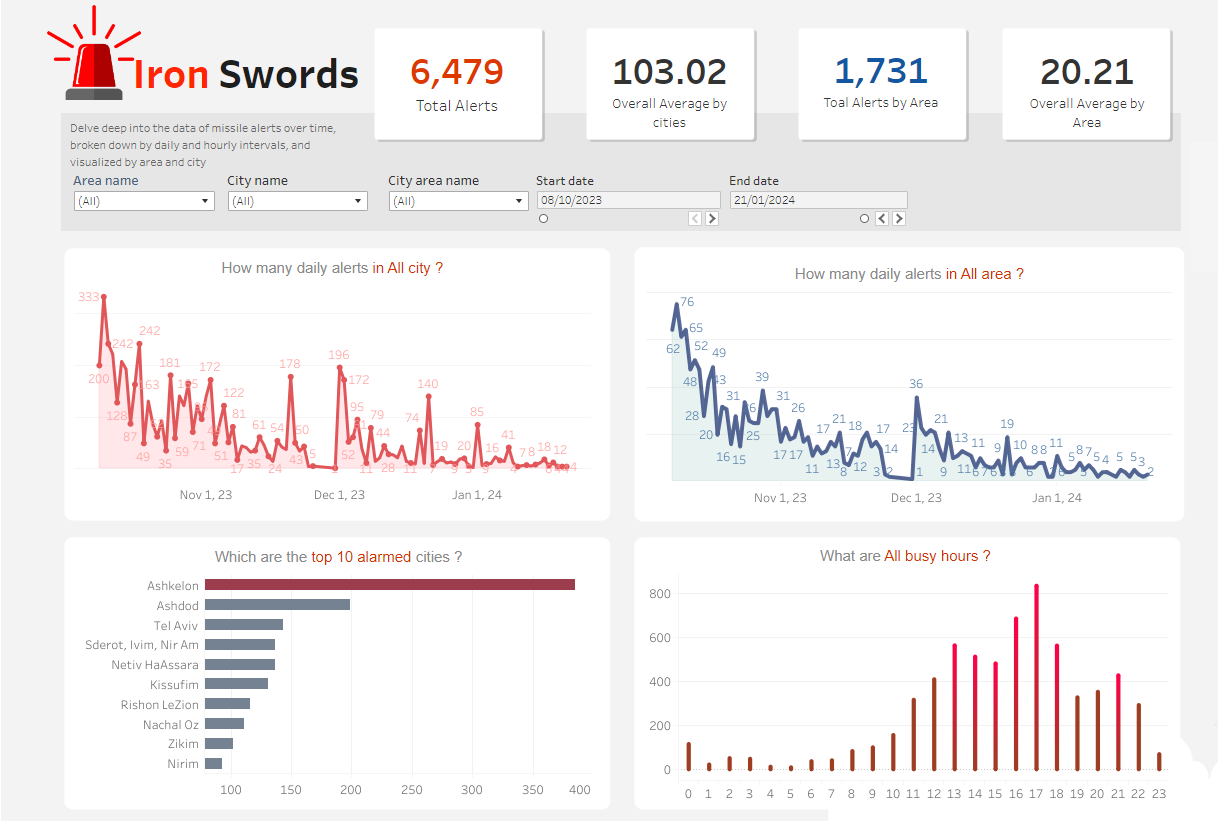

In [146]:
df_alerts = pd.read_csv('/content/Cities Overall_Full Data_data.csv')
df_alerts['Alert Date'] = pd.to_datetime(df_alerts['Alert Date'], format='%m/%d/%Y %I:%M:%S %p')

In [147]:
display(df_alerts)
df_alerts.info()

,City Name,Areaname,date filter,Alert Date,Counted Alerts
0,Tel Aviv,Dan,True,2023-10-31 14:33:00,1
1,Tel Aviv,Dan,True,2023-10-31 18:27:00,1
2,Tel Aviv,Dan,True,2023-10-31 21:02:00,1
3,Tel Aviv,Dan,True,2023-10-31 21:02:00,1
4,Tel Aviv,Dan,True,2023-10-31 18:27:00,1
...,...,...,...,...,...
1549,Ashkelon,West Lachish,True,2023-10-28 22:59:00,1
1550,Ashkelon,West Lachish,True,2023-12-28 17:25:00,1
1551,Ashkelon,West Lachish,True,2023-10-30 11:24:00,1
1552,Ashkelon,West Lachish,True,2023-10-30 20:00:00,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   City Name       1554 non-null   object        
 1   Areaname        1554 non-null   object        
 2   date filter     1554 non-null   bool          
 3   Alert Date      1554 non-null   datetime64[ns]
 4   Counted Alerts  1554 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int64(1), object(2)
memory usage: 50.2+ KB


Comparative Analysis of Words during Alerts and Not During Alerts:



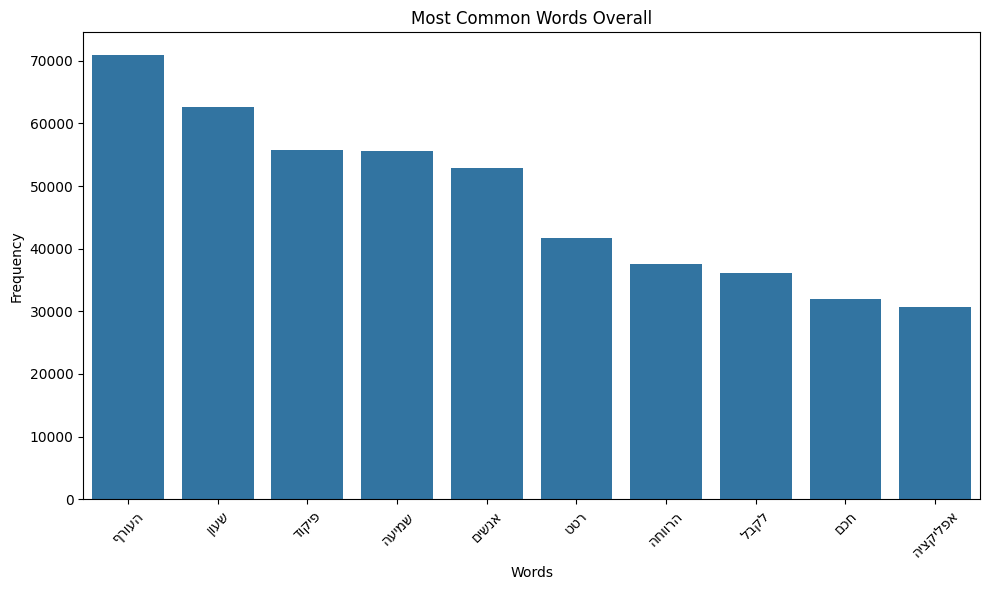

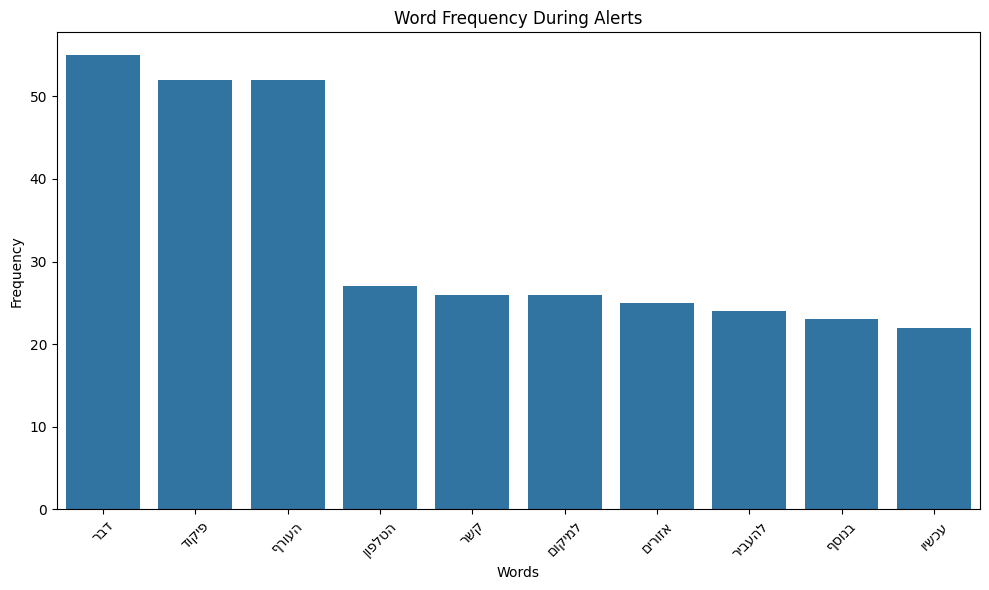

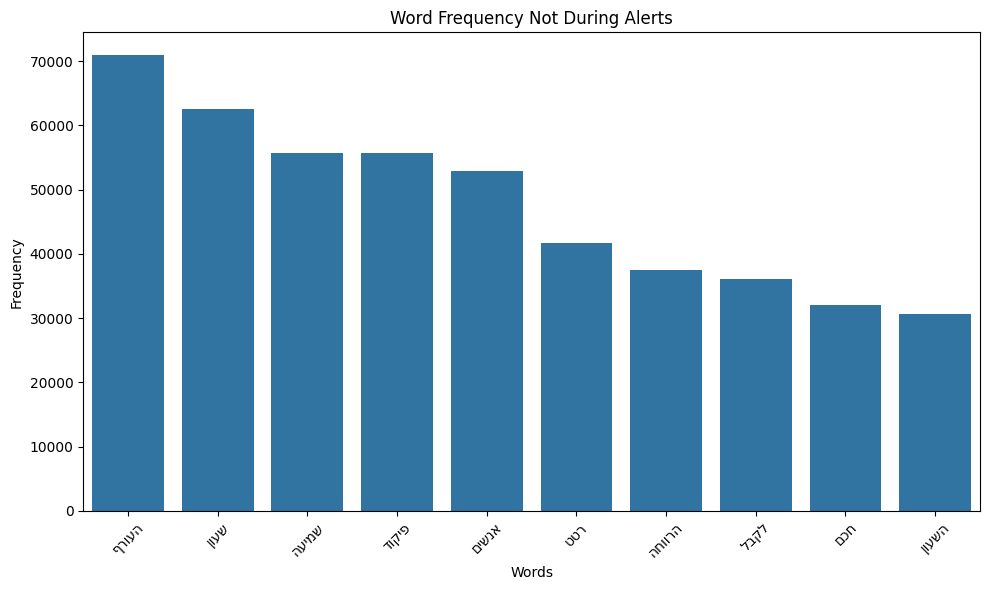

In [148]:
def extract_words(text):
    return text.split()

# Function to find words around the same time as alerts
def find_related_words(df_alerts, df_copy):
    related_words_during_alerts = []
    related_words_not_during_alerts = []

    for index, alert_row in df_alerts.iterrows():
        alert_time = alert_row['Alert Date']
        start_time = alert_time - timedelta(minutes=15)
        end_time = alert_time + timedelta(minutes=15)

        related_texts = df_copy[(df_copy['datetime'] >= start_time) & (df_copy['datetime'] <= end_time)]['cleaned_message']

        if not related_texts.empty:
            for text in related_texts:
                words = extract_words(text)
                related_words_during_alerts.extend(words)
        else:
            related_texts = df_copy[(df_copy['datetime'] < start_time) | (df_copy['datetime'] > end_time)]['cleaned_message']
            for text in related_texts:
                words = extract_words(text)
                related_words_not_during_alerts.extend(words)

    # Count word frequency
    during_alerts_counter = Counter(related_words_during_alerts)
    not_during_alerts_counter = Counter(related_words_not_during_alerts)

    # Find unique words
    unique_words_during_alerts = set(related_words_during_alerts)
    unique_words_not_during_alerts = set(related_words_not_during_alerts)

    # Find most common words overall
    most_common_overall = (during_alerts_counter + not_during_alerts_counter).most_common(10)

    print("Comparative Analysis of Words during Alerts and Not During Alerts:\n")

    # Plot most common words overall
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word[::-1] for word, _ in most_common_overall], y=[count for _, count in most_common_overall])
    plt.title('Most Common Words Overall')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot word frequency during alerts
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word[::-1] for word, count in during_alerts_counter.most_common(10)], y=[count for _, count in during_alerts_counter.most_common(10)])
    plt.title('Word Frequency During Alerts')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot word frequency not during alerts
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word[::-1] for word, count in not_during_alerts_counter.most_common(10)], y=[count for _, count in not_during_alerts_counter.most_common(10)])
    plt.title('Word Frequency Not During Alerts')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

find_related_words(df_alerts, df_copy)

In [149]:
def extract_words(text):
    return text.split()

# Function to find words around the same time as alerts
def find_related_words(df_alerts, df_copy):
    related_words_during_alerts = []
    related_words_not_during_alerts = []

    for index, alert_row in df_alerts.iterrows():
        alert_time = alert_row['Alert Date']
        start_time = alert_time - timedelta(minutes=15)
        end_time = alert_time + timedelta(minutes=15)

        related_texts = df_copy[(df_copy['datetime'] >= start_time) & (df_copy['datetime'] <= end_time)]['cleaned_message']

        if not related_texts.empty:
            for text in related_texts:
                words = extract_words(text)
                related_words_during_alerts.extend(words)
        else:
            related_texts = df_copy[(df_copy['datetime'] < start_time) | (df_copy['datetime'] > end_time)]['cleaned_message']
            for text in related_texts:
                words = extract_words(text)
                related_words_not_during_alerts.extend(words)

    # Count word frequency
    during_alerts_counter = Counter(related_words_during_alerts)
    not_during_alerts_counter = Counter(related_words_not_during_alerts)

    # Find the 20 most common words during alerts
    common_words_during_alerts = [word for word, _ in during_alerts_counter.most_common(20)]

    # Find the 20 most common words not during alerts
    common_words_not_during_alerts = [word for word, _ in not_during_alerts_counter.most_common(20)]

    # Convert the lists to sets for easy comparison
    set_during_alerts = set(common_words_during_alerts)
    set_not_during_alerts = set(common_words_not_during_alerts)

    # Find the intersection and dissimilarity between the sets
    common_during_and_not = set_during_alerts.intersection(set_not_during_alerts)
    unique_to_during_alerts = set_during_alerts - set_not_during_alerts
    unique_to_not_during_alerts = set_not_during_alerts - set_during_alerts

    print("Common Words During Alerts and Not During Alerts:", common_during_and_not)
    print("Unique Words During Alerts:", unique_to_during_alerts)
    print("Unique Words Not During Alerts:", unique_to_not_during_alerts)

find_related_words(df_alerts, df_copy)

Common Words During Alerts and Not During Alerts: {'פיקוד', 'העורף', 'רטט'}
Unique Words During Alerts: {'עוד', 'להעביר', 'עכשיו', 'אפליקציות', 'אזורים', 'איזורי', 'בנוסף', 'אינטרנט', 'למיקום', 'מספר', 'קודם', 'שקט', 'נושא', 'דבר', 'הטלפון', 'קשר', 'מכירים'}
Unique Words Not During Alerts: {'היום', 'התראה', 'תקשורת', 'שמיעה', 'השעון', 'שעונים', 'אזעקה', 'עובד', 'אפליקציה', 'חכם', 'החזר', 'ההזמנה', 'לקבל', 'אנשים', 'שעון', 'הרווחה', 'בוקר'}


In [150]:
df_copy['datetime'] = pd.to_datetime(df_copy['datetime'])
df_alerts['Alert Date'] = pd.to_datetime(df_alerts['Alert Date'])

# Function to check if a datetime is within 10 minutes of any alert date
def during_alert(date, alerts):
    for alert_date in alerts:
        if abs((date - alert_date).total_seconds()) <= 600:
            return 1
    return 0

df_copy['during alert'] = df_copy['datetime'].apply(lambda x: during_alert(x, df_alerts['Alert Date']))
df_messages_with_alert_tags = df_copy
display(df_messages_with_alert_tags)

,date,time,person,message,cleaned_message,datetime,message_length,word_count,hour_of_day,day_of_week,during alert
0,11.7.2023,6:56:49,"כו""ח - על כל שאלה תשובה",‏ההודעות והשיחות מוצפנות מקצה לקצה. לאף אחד מח...,ההודעות והשיחות מוצפנות מקצה לקצה לאף לצאט לwh...,2023-07-11 06:56:49,112,23,6,2,0
1,21.8.2023,17:32:38,רועי מרלי,‏סקר:,סקר,2023-08-21 17:32:38,5,2,17,1,0
2,8.10.2023,22:22:51,יעל גורן (מפילדלפיה),האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...,אפשרות באפליקציה לשנות צליל ההתראה מסירנה למשה...,2023-10-08 22:22:51,84,17,22,0,1
3,22.10.2023,23:15:45,יניב פיבו,‫‏לירית שפיר שמש הסיר/ה את יניב פיבו‬,לירית שפיר שמש הסירה יניב פיבו,2023-10-22 23:15:45,37,7,23,0,0
4,22.10.2023,23:20:16,~ M.B.N. ltd,‫‏לירית שפיר שמש הסיר/ה את ~ M.B.N. ltd‬,לירית שפיר שמש הסירה mbn ltd,2023-10-22 23:20:16,40,9,23,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1541,7.11.2023,11:40:51,דורית בן שלום,מה שהצעתי .,שהצעתי,2023-11-07 11:40:51,11,3,11,2,0
1542,7.11.2023,11:41:06,רונן ברנוי,יאללה חמודים/ות... יאללה...,יאללה חמודיםות יאללה,2023-11-07 11:41:06,27,5,11,2,0
1543,7.11.2023,11:41:16,יעקב וובר,כמו שאמרתי אין השבע יודע את מצוקת הרעב,שאמרתי השבע יודע מצוקת הרעב,2023-11-07 11:41:16,38,8,11,2,0
1544,7.11.2023,12:00:33,~ Meitav,כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...,חכמה גדולה והבנה מושלמת והבנה לוקה בחוסר,2023-11-07 12:00:33,56,11,12,2,0


In [151]:
print(df_messages_with_alert_tags['during alert'].value_counts())

0    1388
1     158
Name: during alert, dtype: int64


In [152]:
display(df_messages_with_alert_tags.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1546 non-null   object        
 1   time             1546 non-null   object        
 2   person           1546 non-null   object        
 3   message          1546 non-null   object        
 4   cleaned_message  1546 non-null   object        
 5   datetime         1546 non-null   datetime64[ns]
 6   message_length   1546 non-null   int64         
 7   word_count       1546 non-null   int64         
 8   hour_of_day      1546 non-null   int64         
 9   day_of_week      1546 non-null   int64         
 10  during alert     1546 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 133.0+ KB


None

In [153]:
# Copy df_messages_with_alert_tags into df_ready
df_ready = df_messages_with_alert_tags.copy()

# Drop columns: date, time, message
df_ready.drop(columns=['date', 'time', 'message'], inplace=True)

# Do label encoding for column "person"
label_encoder = LabelEncoder()
df_ready['person'] = label_encoder.fit_transform(df_ready['person'])

# Perform TruncatedSVD on "cleaned_message" to reduce dimensionality
svd = TruncatedSVD(n_components=20)
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
svd_pipeline = make_pipeline(tfidf_vectorizer, svd)
cleaned_message_svd = svd_pipeline.fit_transform(df_ready['cleaned_message'])

# Scale the "hour of day" column from 0 to 1
df_ready['hour_of_day'] = df_ready['hour_of_day'] / 23.0

# Scale "day of week" column from 0 to 1
df_ready['day_of_week'] = df_ready['day_of_week'] / 6.0

# Scale "message_length" and "word_count" columns using min-max scaling
scaler = MinMaxScaler()
df_ready[['message_length', 'word_count']] = scaler.fit_transform(df_ready[['message_length', 'word_count']])

# Combine the TruncatedSVD results with the original DataFrame
df_ready = pd.concat([df_ready.drop(columns=['cleaned_message']), pd.DataFrame(cleaned_message_svd)], axis=1)

display(df_ready)

,person,datetime,message_length,word_count,hour_of_day,day_of_week,during alert,0,1,2,...,10,11,12,13,14,15,16,17,18,19
0,111,2023-07-11 06:56:49,0.145098,0.142857,0.260870,0.333333,0,0.000986,-0.000038,0.003329,...,-0.001877,-0.000303,-0.004196,-0.003992,0.001386,-0.000196,-0.000900,-0.001181,0.001047,0.003858
1,141,2023-08-21 17:32:38,0.005229,0.006494,0.739130,0.166667,0,0.006075,-0.001179,-0.002057,...,-0.003722,0.001467,-0.091387,-0.029382,0.227440,-0.039236,-0.012702,-0.048292,-0.061709,-0.056990
2,107,2023-10-08 22:22:51,0.108497,0.103896,0.956522,0.000000,1,0.020215,-0.000012,0.004170,...,-0.005901,-0.004789,-0.007565,-0.000773,0.001084,-0.005928,0.029600,-0.019867,0.012769,0.003046
3,105,2023-10-22 23:15:45,0.047059,0.038961,1.000000,0.000000,0,0.001404,-0.000183,0.003526,...,-0.005768,0.003256,0.002573,-0.006900,-0.014940,-0.000356,0.003245,-0.006301,-0.005629,-0.011591
4,12,2023-10-22 23:20:16,0.050980,0.051948,1.000000,0.000000,0,0.001404,-0.000183,0.003526,...,-0.005768,0.003256,0.002575,-0.006899,-0.014940,-0.000357,0.003245,-0.006298,-0.005630,-0.011588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,92,2023-11-07 11:40:51,0.013072,0.012987,0.478261,0.333333,0,0.000002,-0.000006,0.000002,...,-0.000049,-0.000118,-0.000048,0.000006,-0.000057,-0.000009,0.000153,0.000282,0.000117,-0.000029
1542,139,2023-11-07 11:41:06,0.033987,0.025974,0.478261,0.333333,0,0.000313,-0.000008,0.000768,...,-0.004238,0.000114,-0.002097,-0.000002,0.000638,-0.005011,0.002458,-0.001325,0.000383,0.003037
1543,109,2023-11-07 11:41:16,0.048366,0.045455,0.478261,0.333333,0,0.002752,0.000675,0.017507,...,0.008563,-0.012332,-0.028215,0.010603,-0.013964,-0.004821,0.009990,-0.007827,-0.025211,0.020329
1544,15,2023-11-07 12:00:33,0.071895,0.064935,0.521739,0.333333,0,0.008459,-0.000155,0.000156,...,-0.005248,0.000743,-0.011716,-0.011283,0.010187,-0.014202,-0.002494,-0.004995,0.001936,0.002620


In [154]:
display(df_ready.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   person          1546 non-null   int64         
 1   datetime        1546 non-null   datetime64[ns]
 2   message_length  1546 non-null   float64       
 3   word_count      1546 non-null   float64       
 4   hour_of_day     1546 non-null   float64       
 5   day_of_week     1546 non-null   float64       
 6   during alert    1546 non-null   int64         
 7   0               1546 non-null   float64       
 8   1               1546 non-null   float64       
 9   2               1546 non-null   float64       
 10  3               1546 non-null   float64       
 11  4               1546 non-null   float64       
 12  5               1546 non-null   float64       
 13  6               1546 non-null   float64       
 14  7               1546 non-null   float64       
 15  8   

None

In [155]:
# Drop datetime column as it's not needed for clustering or dimensionality reduction
df_ready.drop(columns=['datetime'], inplace=True)

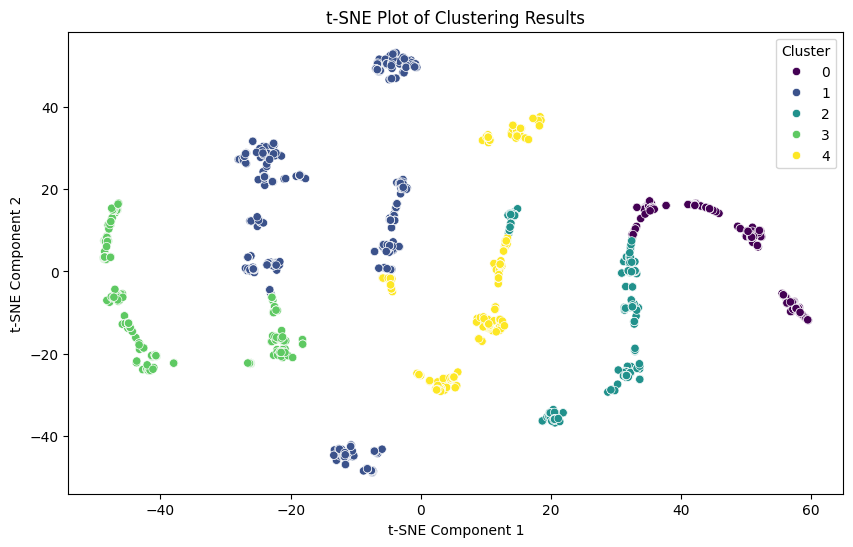

Cluster Centers:
[[ 1.79800000e+01  5.45359477e-02  5.15259740e-02  5.96956522e-01
   2.95000000e-01  7.50000000e-02  3.18623124e-02  2.13100307e-02
   1.48934978e-02  2.01804041e-02  8.64155324e-03  1.92987047e-02
   1.39197048e-02  2.37030774e-03  6.13198401e-03  1.80742593e-03
   2.59256589e-03  7.58031552e-03 -7.52108233e-03  3.87857920e-05
  -5.79925764e-03 -6.93633013e-03  7.95094732e-03 -3.99181048e-03
  -3.57098651e-03  6.38644418e-03]
 [ 1.10562900e+02  6.61510375e-02  6.39381940e-02  5.84685269e-01
   4.82231699e-01  6.60980810e-02  1.65249572e-02  9.03464271e-06
   1.84338828e-02  1.77617098e-02 -2.71951358e-04 -4.02418652e-03
   2.99976554e-03  8.73894051e-03  1.07423816e-02  1.48933660e-02
  -2.72255004e-03  1.27542648e-02 -9.17066927e-03  6.93956281e-04
   5.64630607e-03 -1.17924278e-03  4.54717223e-03  2.51744544e-03
   4.21242701e-03  2.72628088e-03]
 [ 5.24921875e+01  5.12867647e-02  5.02993101e-02  5.80163043e-01
   3.71093750e-01  8.98437500e-02  1.91886929e-02  4.05

In [156]:
# Convert feature names to strings
df_ready.columns = df_ready.columns.astype(str)

# Perform clustering with KMeans
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(df_ready)

# Perform dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_ready)

# Visualize clustering results using t-SNE plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('t-SNE Plot of Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

print("Cluster Centers:")
print(kmeans.cluster_centers_)
print("\nCluster Sizes:")
print(df_ready.groupby(cluster_labels).size())


In [157]:
# Combine cluster labels with the original DataFrame
df_with_clusters = df_ready.copy()
df_with_clusters['cluster'] = cluster_labels

# Calculate proportion of messages during alert for each cluster
cluster_alert_proportion = df_with_clusters.groupby('cluster')['during alert'].mean()

print("Proportion of Messages During Alert for Each Cluster:")
print(cluster_alert_proportion)

Proportion of Messages During Alert for Each Cluster:
cluster
0    0.075000
1    0.066098
2    0.089844
3    0.109375
4    0.179402
Name: during alert, dtype: float64


In [158]:
for i, cluster_center in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i+1}:")

    # Analyze person distribution
    person_avg = cluster_center[0]
    print(f"   - Person Distribution: Average person index = {person_avg}")

    # Analyze message length and word count
    message_length_avg = cluster_center[1]
    word_count_avg = cluster_center[2]
    print(f"   - Message Length: Average message length = {message_length_avg}")
    print(f"   - Word Count: Average word count = {word_count_avg}")

    # Analyze time of day and day of week
    hour_of_day_avg = cluster_center[3]
    day_of_week_avg = cluster_center[4]
    print(f"   - Time of Day: Average hour of day = {hour_of_day_avg}")
    print(f"   - Day of Week: Average day of week = {day_of_week_avg}")

    # Analyze activity during alerts
    during_alert_avg = cluster_center[5]
    print(f"   - Activity During Alerts: Proportion of messages during alerts = {during_alert_avg}")

    # Analyze TF-IDF features
    tfidf_features_avg = cluster_center[6:]
    top_tfidf_indices = tfidf_features_avg.argsort()[-5:][::-1]  # Get indices of top 5 TF-IDF features
    print("   - Top TF-IDF Features:")
    for idx in top_tfidf_indices:
        print(f"      - TF-IDF Feature {idx}: {tfidf_features_avg[idx]}")

    print("\n")

Cluster 1:
   - Person Distribution: Average person index = 17.979999999999862
   - Message Length: Average message length = 0.05453594771241829
   - Word Count: Average word count = 0.05152597402597403
   - Time of Day: Average hour of day = 0.5969565217391304
   - Day of Week: Average day of week = 0.29500000000000015
   - Activity During Alerts: Proportion of messages during alerts = 0.07500000000000007
   - Top TF-IDF Features:
      - TF-IDF Feature 0: 0.031862312355156394
      - TF-IDF Feature 1: 0.021310030690709865
      - TF-IDF Feature 3: 0.02018040407962074
      - TF-IDF Feature 5: 0.01929870474066887
      - TF-IDF Feature 2: 0.014893497807379186


Cluster 2:
   - Person Distribution: Average person index = 110.56289978678026
   - Message Length: Average message length = 0.06615103752943961
   - Word Count: Average word count = 0.0639381940021599
   - Time of Day: Average hour of day = 0.5846852693056456
   - Day of Week: Average day of week = 0.48223169864960913
   - Act


*   Cluster 1: Active Participants with Moderate Message Length
*   Cluster 2: Active Participants with Longer Messages and Specific Terms
*   Cluster 3: Moderate Participants with Balanced Activity
*   Cluster 4: Highly Active Participants with Longer Messages
*   Cluster 5: Highly Active Participants with Varied Message Lengths

Despite the challenges posed by the war, the existence of multiple clusters with varying communication patterns suggests that deaf individuals demonstrate resilience and adaptability in navigating uncertain circumstances. Some clusters may prioritize staying informed and connected, while others may focus on maintaining a sense of normalcy and social interaction.

Throughout the experimentation process, I explored various perspectives and examined response patterns to identify any anomalies in the communication dynamics within chat groups of deaf individuals. However, my findings consistently revealed that deaf individuals respond actively and in line with expected behaviors. It might be beneficial to look into the sentiment and topics discussed in the chats for further understanding.